#### imports

In [23]:
import torch
import os

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from transformers import AutoModel, AutoTokenizer
from torchvision import transforms

#### model

In [3]:
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [4]:
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True, torch_dtype=torch.bfloat16)
model = model.to(device='cuda', dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#### dataset

In [43]:
path = '../full_images'
files = os.listdir(path)
full_images = [file for file in files if file.endswith('.tif')]

full_images.sort()
full_image = os.path.join(path, full_images[0])
img = Image.open(full_image).convert('RGB')

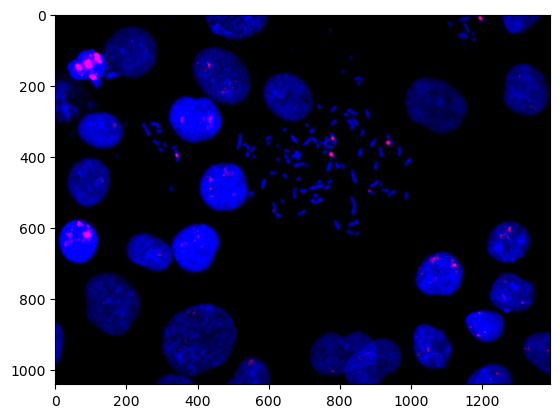

In [44]:
plt.imshow(img)

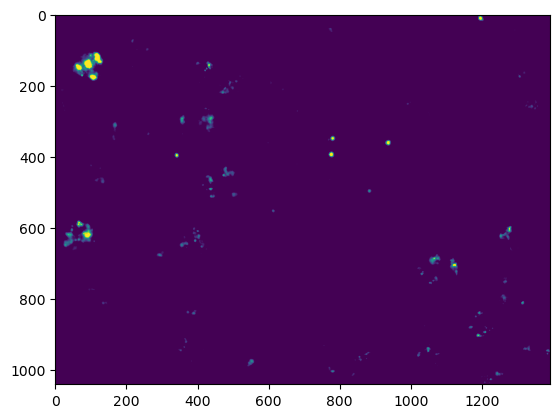

In [36]:
plt.imshow(img[:,:,0])

#### workspace

In [45]:
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True)
model.eval()

question = 'How many chromosomes are in the following picture. Give only a number'
msgs = [{'role': 'user', 'content': question}]

res, context, _ = model.chat(
    image=img,
    msgs=msgs,
    context=None,
    tokenizer=tokenizer,
    sampling=True,
    temperature=0.7
)
print(res)

17


In [8]:
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True)
model.eval()

image = Image.open('../../test.png').convert('RGB')

question = 'You are a bioligist who is studying extrachromosomal DNA. Describe the image.'
msgs = [{'role': 'user', 'content': question}]

res, context, _ = model.chat(
    image=image,
    msgs=msgs,
    context=None,
    tokenizer=tokenizer,
    sampling=True,
    temperature=0.7
)
print(res)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


The image depicts a microscopic view of extrachromosomal DNA. The cells in the picture are stained with blue, indicating that they contain high concentrations or specific types of proteins and other molecules associated with this type of genetic material.


In [9]:
print(context)

[{'role': 'user', 'content': 'You are a bioligist who is studying extrachromosomal DNA. Describe the image.'}, {'role': 'assistant', 'content': 'The image depicts a microscopic view of extrachromosomal DNA. The cells in the picture are stained with blue, indicating that they contain high concentrations or specific types of proteins and other molecules associated with this type of genetic material.'}]
